# English-to-Spanish translation with a sequence-to-sequence Transformer



**Author:** [fchollet](https://twitter.com/fchollet)<br>

**Date created:** 2021/05/26<br>

**Last modified:** 2023/02/25<br>

**Description:** Implementing a sequence-to-sequence Transformer and training it on a machine translation task.

## Introduction



In this example, we'll build a sequence-to-sequence Transformer model, which

we'll train on an English-to-Spanish machine translation task.



You'll learn how to:



- Vectorize text using the Keras `TextVectorization` layer.

- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,

and a `PositionalEmbedding` layer.

- Prepare data for training a sequence-to-sequence model.

- Use the trained model to generate translations of never-seen-before

input sentences (sequence-to-sequence inference).



The code featured here is adapted from the book

[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)

(chapter 11: Deep learning for text).

The present example is fairly barebones, so for detailed explanations of

how each building block works, as well as the theory behind Transformers,

I recommend reading the book.

## Setup

In [ ]:
# We set the backend to TensorFlow. The code works with

# both `tensorflow` and `torch`. It does not work with JAX

# due to the behavior of `jax.numpy.tile` in a jit scope

# (used in `TransformerDecoder.get_causal_attention_mask()`:

# `tile` in JAX does not support a dynamic `reps` argument.

# You can make the code work in JAX by wrapping the

# inside of the `get_causal_attention_mask` method in

# a decorator to prevent jit compilation:

# `with jax.ensure_compile_time_eval():`.

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings


import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
from keras_nlp.metrics import Perplexity

import json

import tensorflow as tf
import seaborn

## Downloading the data



We'll be working with an English-to-Spanish translation dataset

provided by [Anki](https://www.manythings.org/anki/). Let's download it:

text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)

tet_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

In [ ]:
def read_text(file_path):
    texts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Parse the JSON line
            data = json.loads(line.strip())
            texts.append((data['src'], '[start] ' + data['dst'].lower() + ' [end]'))

    return texts

In [4]:
train_pairs = read_text('/kaggle/input/machine-translation-from-alien/train')

In [19]:
train_pairs[:2]

[('◄▴◓◠▨ ◨▽◠▦◈◬◓▪▼◬▵', '[start] - intriguing. [end]'),
 ('▽◪◎◗▦◫▦◫ ▫▴▨◓◠◓ ▴▫◎◪▱◫ ◚▴ ◞◧▦◞▾▢▱◨▨ ◒◠◓◠◀▪▦◈◠▦ ◫◉◎▴▱◫▵',
  '[start] he would need to repeat his vows in the land of the living and drink from the wine of ages. [end]')]

In [6]:
val_pairs = read_text('/kaggle/input/machine-translation-from-alien/val')

In [7]:
val_pairs[:2]

[("◘◚ ◞◠▷◫◀◗ ▫◠▨◬◎ ▨◪▦◈◫▦◫ ▫◧▻▱◠◈▪ ◚◪ ◝◂▾▼▷◠◓◈'◬▦ 27:37'◈▴▨◗ ◕◂▱◭ ◀◗◓ ▨▴▢ ◈◠▷◠ ◞▨◂◓◨ ▴◒◗▫▱◪◈◗▵",
  '[start] the hosts regrouped, and bouchard evened the score again, scoring a goal with a 27-37 man advantage. [end]'),
 ('◤◪▦◫ ▨◠▦◞▴◓ ◠◒▪◞▪■ ◀◠◐▪◒◬▨▱▪▨ ◞◫◞▫◪◎◫▦▴ ▨◣▫◭ ▦◫◳◪▫▱◗ ▷▩▼◓◪▱▴◓◫ "◕◣◓◎▴▽◫" ◇◐◓◪▫▴◀◫▱◗◓',
  '[start] a new cancer vaccine may teach the immune system to "see" abnormal cells [end]')]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


99th in alien: 116.0
95th in alien: 75.0
50th in alien: 28.0


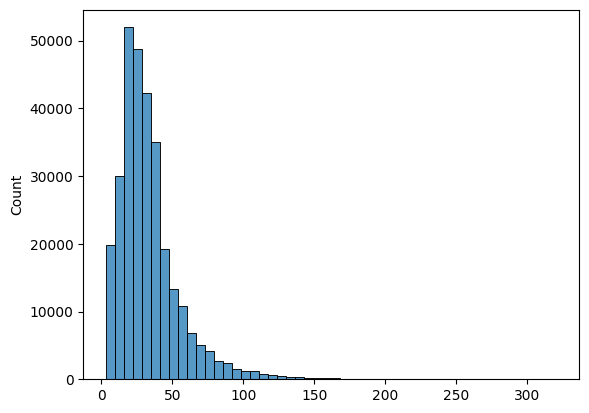

In [26]:
length_seq = []

for seq in train_pairs:
    length_seq.append(len(seq[0]))


seaborn.histplot(length_seq, bins=50)
print('99th in alien:', np.percentile(length_seq, 99))
print('95th in alien:', np.percentile(length_seq, 95))
print('50th in alien:', np.percentile(length_seq, 50))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


95th in eng: 102.0
50th in eng: 45.0


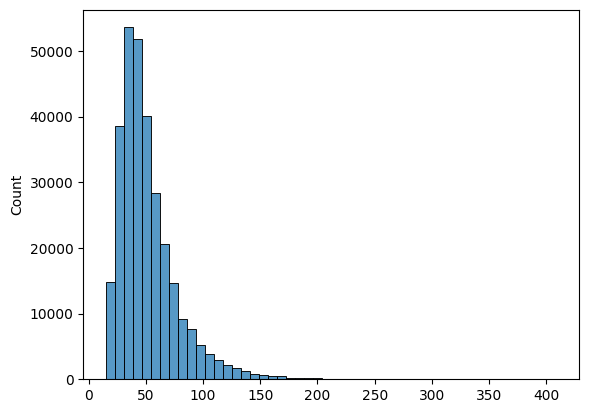

In [24]:
length_seq = []

for seq in train_pairs:
    length_seq.append(len(seq[1]))


seaborn.histplot(length_seq, bins=50)
print('95th in eng:', np.percentile(length_seq, 95))
print('50th in eng:', np.percentile(length_seq, 50))

## Parsing the data



Each line contains an English sentence and its corresponding Spanish sentence.

The English sentence is the *source sequence* and Spanish one is the *target sequence*.

We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

## Alt vectorization

ENG_VOCAB_SIZE = 80000
ALIEN_VOCAB_SIZE = 12000

def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf_data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

with tf.device('/GPU:0'): 
    alien_samples = [text_pair[0] for text_pair in train_pairs]
    alien_vocab = train_word_piece(alien_samples, ALIEN_VOCAB_SIZE, reserved_tokens)
    
with tf.device('/GPU:0'): 
    eng_samples = [text_pair[1] for text_pair in train_pairs]
    eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

alien_tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary=alien_vocab, lowercase=False
)
eng_tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=True
)

## Vectorizing the text data



We'll use two instances of the `TextVectorization` layer to vectorize the text

data (one for English and one for Spanish),

that is to say, to turn the original strings into integer sequences

where each integer represents the index of a word in a vocabulary.



The English layer will use the default string standardization (strip punctuation characters)

and splitting scheme (split on whitespace), while

the Spanish layer will use a custom standardization, where we add the character

`"¿"` to the set of punctuation characters to be stripped.



Note: in a production-grade machine translation model, I would not recommend

stripping the punctuation characters in either language. Instead, I would recommend turning

each punctuation character into its own token,

which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [45]:
strip_chars = string.punctuation + ""
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 85000
sequence_length = 70
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


def split_alien_text(text):
  text = text.numpy()
  decoded_text = tf.strings.unicode_decode(text, 'UTF-8')
  return list(decoded_text.decode('UTF-8'))


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    #split='character',
    standardize=None,
    #ngrams=3

)

spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    split='whitespace',
    standardize='lower'
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [46]:
eng_vectorization("◄▴◓◠▨ ◨▽◠▦◈◬◓▪▼◬▵")

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([ 3017, 90835,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])>

In [47]:
spa_vectorization("[start] - intriguing. [end]")

<tf.Tensor: shape=(31,), dtype=int64, numpy=
array([    2,    10, 30819,     3,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])>

In [48]:
# Example sentence

example_sentence = "As of Sunday morning, the hurricane, which has a maximum wind speed of 137 km/h, is located 360 km south of Punta Eugenia, Mexico, and is moving north at a speed of 19 km/h."
example_sentence_1 = "□◠▢◠◓ ◞◠◀◠▷▪ ◞◠◠▫▫▴ 85 ◎◫▱ ◎◠▨◞◫◎▾◎ ◓◭▢◕◠◓ ▷▪▢◬◳▱◠ ▷â▱â ▨◠◞◬◓◕◠ ▨◨◚◚◪▫◗▦◈▴ ◧▱◠▦ ▤◂◞◠■ □◨▦▫◠ ◰▾◕◪▦◫◠■ ◄◪▨◞◗▨◠'▦◬▦ 385 ◎◗▱ ◕▩▦◪▽◫▦◈▴ ◀◨▱◨▦◨▽◂◓ ◚▴ ◞◠◠▫▫▴ 12 ◎◗▱ ▷▪▢▱◠ ▨◨▢▴▽▴ ◈◂◐◓◨ ◗▱◪◓▱◗◳◂◓▵"


# Convert it to a tensor

example_tensor = tf.convert_to_tensor([example_sentence])
example_tensor_1 = tf.convert_to_tensor([example_sentence_1])


# Tokenize using the English TextVectorization layer
tokenized_output = eng_vectorization(example_tensor_1)
tokenized_output_1 = spa_vectorization(example_tensor)


# Print the tokenized output
print("Tokenized Output:", tokenized_output.numpy())
print("Tokenized Output:", tokenized_output_1.numpy())


# To inspect tokens mapped to vocabulary indices
vocabulary = eng_vectorization.get_vocabulary()
vocabulary_1 = spa_vectorization.get_vocabulary()

decoded_tokens = [vocabulary[token] for token in tokenized_output[0].numpy()]
decoded_tokens_1 = [vocabulary_1[token] for token in tokenized_output_1[0].numpy()]

print("Decoded Tokens:", decoded_tokens)
print("Decoded Tokens:", decoded_tokens_1)

Tokenized Output: [[ 2965 23147  3312 40409  4056 54681 19177     1   288 69432     1   100
  71476     1     1     1     1  3466     1     1     5  3312  1013  3466
   4334     1   470     1     0     0]]
Tokenized Output: [[   58    11  2912   939     4 66527   224   100     8 12300  2136  2050
     11     1     1    14  4298 36253 21616  1397    11 52015     1  9708
      9    14   852  1306    46     8  2050]]
Decoded Tokens: ['□◠▢◠◓', '◞◠◀◠▷▪', '◞◠◠▫▫▴', '85', '◎◫▱', '◎◠▨◞◫◎▾◎', '◓◭▢◕◠◓', '[UNK]', '▷â▱â', '▨◠◞◬◓◕◠', '[UNK]', '◧▱◠▦', '▤◂◞◠■', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '◎◗▱', '[UNK]', '[UNK]', '◚▴', '◞◠◠▫▫▴', '12', '◎◗▱', '▷▪▢▱◠', '[UNK]', '◈◂◐◓◨', '[UNK]', '', '']
Decoded Tokens: ['as', 'of', 'sunday', 'morning,', 'the', 'hurricane,', 'which', 'has', 'a', 'maximum', 'wind', 'speed', 'of', '[UNK]', '[UNK]', 'is', 'located', '360', 'km', 'south', 'of', 'punta', '[UNK]', 'mexico,', 'and', 'is', 'moving', 'north', 'at', 'a', 'speed']


Next, we'll format our datasets.



At each training step, the model will seek to predict target words N+1 (and beyond)

using the source sentence and the target words 0 to N.



As such, the training dataset will yield a tuple `(inputs, targets)`, where:



- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.

`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",

that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.

- `target` is the target sentence offset by one step:

it provides the next words in the target sentence -- what the model will try to predict.

In [49]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)

    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes

(we have batches of 64 pairs, and all sequences are 20 steps long):

In [50]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 30)
inputs["decoder_inputs"].shape: (128, 30)
targets.shape: (128, 30)


In [51]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"]: {inputs["encoder_inputs"][:1]}')
    print(f'inputs["decoder_inputs"]: {inputs["decoder_inputs"][:1]}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"]: [[   2 1312   32    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
inputs["decoder_inputs"]: [[  2  10 163 138   3   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
targets.shape: (128, 30)


## Building the model



Our sequence-to-sequence Transformer consists of a `TransformerEncoder`

and a `TransformerDecoder` chained together. To make the model aware of word order,

we also use a `PositionalEmbedding` layer.



The source sequence will be pass to the `TransformerEncoder`,

which will produce a new representation of it.

This new representation will then be passed

to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).

The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).



A key detail that makes this possible is causal masking

(see method `get_causal_attention_mask()` on the `TransformerDecoder`).

The `TransformerDecoder` sees the entire sequences at once, and thus we must make

sure that it only uses information from target tokens 0 to N when predicting token N+1

(otherwise, it could use information from the future, which would

result in a model that cannot be used at inference time).

In [52]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim,
            dropout=0.25
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dropout(0.5),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim


    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions



    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)


    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config



class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim, 
            dropout=0.25
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim,
            dropout=0.25
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dropout(0.5),
                layers.Dense(embed_dim),
            ]
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True



    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)



    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)


    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

Next, we assemble the end-to-end model.

In [53]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## Training our model



We'll use accuracy as a quick way to monitor training progress on the validation data.

Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.



Here we only train for 1 epoch, but to get the model to actually converge

you should train for at least 30 epochs.

In [54]:
epochs = 20 # This should be at least 30 for convergence
loss = tf.keras.losses.SparseCategoricalCrossentropy()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
)

metric = Perplexity()


with tf.device('/GPU:0'): 
    transformer.summary()
    transformer.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule), 
        loss=loss, 
        metrics=[metric]
    )
    transformer.fit(
        train_ds, epochs=epochs, 
        validation_data=val_ds, callbacks=[early_stopping]
    )

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │ 25,607,680 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ (None, None,      │ 56,567,200 │ decoder_inputs[0… │
│ (Functional)        │ 100000)           │            │ transformer_enco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,330,336 (325.51 MB)

 Trainable params: 85,330,336 (325.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


W0000 00:00:1732039579.310592      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732039579.728054      98 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1152/1563 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - loss: 2.4670 - perplexity: 432.2449

W0000 00:00:1732039769.421799      95 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732039769.708068      95 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.2976 - perplexity: 320.2116

W0000 00:00:1732039843.933385      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732039843.936941      97 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732039845.618917      96 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732039845.620546      96 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 275s 164ms/step - loss: 2.2973 - perplexity: 320.0107 - val_loss: 5.1269 - val_perplexity: 168.4964
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 241s 154ms/step - loss: 1.5331 - perplexity: 4.6326 - val_loss: 5.1035 - val_perplexity: 164.5975
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 241s 154ms/step - loss: 1.4370 - perplexity: 4.2082 - val_loss: 5.0754 - val_perplexity: 160.0420
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 241s 154ms/step - loss: 1.3582 - perplexity: 3.8898 - val_loss: 5.1027 - val_perplexity: 164.4701
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 240s 154ms/step - loss: 1.2952 - perplexity: 3.6517 - val_loss: 5.2336 - val_perplexity: 187.4724


## Decoding test sentences



Finally, let's demonstrate how to translate brand new English sentences.

We simply feed into the model the vectorized English sentence

as well as the target token `"[start]"`, then we repeatedly generated the next token, until

we hit the token `"[end]"`.

In [55]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 70


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token


        if sampled_token == "[end]":
            break
    return decoded_sentence

In [56]:
decode_sequence("◤◪▦◫ ▨◠▦◞▴◓ ◠◒▪◞▪■ ◀◠◐▪◒◬▨▱▪▨ ◞◫◞▫◪◎◫▦▴ ▨◣▫◭ ▦◫◳◪▫▱◗ ▷▩▼◓◪▱▴◓◫ \"◕◣◓◎▴▽◫\" ◇◐◓◪▫▴◀◫▱◗◓")

'[start] i was just trying to get a new york city of the world and the world of the world in the world of the world is'

In [27]:
def read_test(file_path):
    texts = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Parse the JSON line
            data = json.loads(line.strip())
            texts.append(data['src'])

    return texts

In [28]:
test = read_test('/kaggle/input/machine-translation-from-alien/test_no_reference')

test[:2]

['◲▦◠▦◬▦■ ◉◗▢◕◗ ◍◗▱◎ ▽◠▽▪▦◠ ◕▴◉◗▦▼▴ ◀◗◓◉◧▨ ◎▴◞◠▸ ◠▱◈▪▨ ◚◪ ◀◨ ◎◪◞◠▸▱◠◓◬▦ ◀◠▢▪▱◠◓▪ ▻◪▨ ◈◂◞▫◉◠ ◈▴◐◫▱◈◗▵',
 '▯▴▥ ◟◧◓▨▱◨ ◀◫◓ ◈◠◈◬■ ◉◂▼◨◐◨▦ ◠▦▦◪◞◗▦◗▦ ▽◠▢◈◬◐▪ ◚◪ ◳◠▦▱▪◒▱▪▨▱◠ ▨▴▦◈◗◞◗▦▴ ◕◣▦◈▴◓◈◗◐◫■ "◀◫◓ ◞◫◳◠▷◗ ◈◠▷◠" ◳◠▢◠▦ ◀◗◓ ◎▴◞◠▸◈◠▦ ◞◧▦◓◠ ▨◪▦◈◫◞◗▦◪ ◠◳◓▪◎▼◬▱◬▨ ◳◠▻▪▱◈▪◐▪ ◚◪ ◗◒◫▦◈◪▦ ▨◂◚◨▱◈▾◐▾ ◫◉◫▦ ◉◗◍▫▴ ◈◠◚◠ ◠◉◬▽◂◓▵']

In [57]:
test_eng_texts = [pair[0] for pair in val_pairs]
references = [pair[1] for pair in val_pairs]

for i in range(5):
    input_sentence = test_eng_texts[i]
    print("Reference:", references[i])
    translated = decode_sequence(input_sentence)
    print("trans:", translated)

Reference: [start] the hosts regrouped, and bouchard evened the score again, scoring a goal with a 27-37 man advantage. [end]
trans: [start] i was just trying to get a new york city and the first time to get to the end of the world and the world of
Reference: [start] a new cancer vaccine may teach the immune system to "see" abnormal cells [end]
trans: [start] i was just trying to get a new york city of the world and the world of the world in the world of the world is
Reference: [start] currently, language subjects are as popular as science, technology, engineering, and mathematics in the curricula of independent schools and other educational institutions. [end]
trans: [start] i was just trying to get to the first of the world and the world of the world of the world and the world who was
Reference: [start] it's no surprise that restaurant chains continue to struggle, especially as a 4.8% drop in sales year-on-year will be particularly painful due to ongoing price pressures. [end]
trans:

In [30]:
preds = []

for sent in test:
    input_sentence = sent
    translated = decode_sequence(input_sentence).replace("[start]", "").replace("[end]", "")
    preds.append((translated, sent))

In [31]:
preds[:2]

[(" i don't know that i was a little bit of the [UNK] and i was a [UNK] and i just like a [UNK] ",
  '◲▦◠▦◬▦■ ◉◗▢◕◗ ◍◗▱◎ ▽◠▽▪▦◠ ◕▴◉◗▦▼▴ ◀◗◓◉◧▨ ◎▴◞◠▸ ◠▱◈▪▨ ◚◪ ◀◨ ◎◪◞◠▸▱◠◓◬▦ ◀◠▢▪▱◠◓▪ ▻◪▨ ◈◂◞▫◉◠ ◈▴◐◫▱◈◗▵'),
 (' i think i can do a [UNK] and the [UNK] and the [UNK] and the [UNK] and the [UNK] and the [UNK] and the [UNK] and',
  '▯▴▥ ◟◧◓▨▱◨ ◀◫◓ ◈◠◈◬■ ◉◂▼◨◐◨▦ ◠▦▦◪◞◗▦◗▦ ▽◠▢◈◬◐▪ ◚◪ ◳◠▦▱▪◒▱▪▨▱◠ ▨▴▦◈◗◞◗▦▴ ◕◣▦◈▴◓◈◗◐◫■ "◀◫◓ ◞◫◳◠▷◗ ◈◠▷◠" ◳◠▢◠▦ ◀◗◓ ◎▴◞◠▸◈◠▦ ◞◧▦◓◠ ▨◪▦◈◫◞◗▦◪ ◠◳◓▪◎▼◬▱◬▨ ◳◠▻▪▱◈▪◐▪ ◚◪ ◗◒◫▦◈◪▦ ▨◂◚◨▱◈▾◐▾ ◫◉◫▦ ◉◗◍▫▴ ◈◠◚◠ ◠◉◬▽◂◓▵')]

In [43]:
# Convert to the desired format
formatted_predictions = []
for dst, src in preds:
    formatted_predictions.append({
        "dst": dst.replace("[start]", "").replace("[end]", "").strip().capitalize(),
        "src": src.strip(),
    })

# Save as JSONL
output_file = "predictions_corr.json"
with open(output_file, "w", encoding="utf-8") as f:
    for item in formatted_predictions:
        f.write(json.dumps(item, ensure_ascii=False, separators=(",", ":")) + "\n")

print(f"Predictions saved to {output_file}")

Predictions saved to predictions_corr.json


After 30 epochs, we get results such as:



> She handed him the money.

> [start] ella le pasó el dinero [end]



> Tom has never heard Mary sing.

> [start] tom nunca ha oído cantar a mary [end]



> Perhaps she will come tomorrow.

> [start] tal vez ella vendrá mañana [end]



> I love to write.

> [start] me encanta escribir [end]



> His French is improving little by little.

> [start] su francés va a [UNK] sólo un poco [end]



> My hotel told me to call you.

> [start] mi hotel me dijo que te [UNK] [end]